In [5]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem 
from rdkit.Chem import AllChem 

from mordred import Calculator, descriptors

from tdc.single_pred import ADME, Tox

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA


from ngboost import NGBRegressor, NGBClassifier
from ngboost.distns import Bernoulli

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, roc_auc_score

In [11]:
def mfs(s):
    return Chem.MolFromSmiles(s)

def mts(m):
    return Chem.MolToCXSmiles(m)

def sanitize_smiles(smi):
    m = Chem.MolFromSmiles(smi) 
    Chem.SanitizeMol(m)
    return Chem.MolToSmiles(m)


def featurize_regression(df, features='ecfp', num_folds=10, fold_size=8, random_seed=100700, make_holdout=False):
    ''' prepare the data for regression setting
    '''
    np.random.seed(random_seed)
    smiles = df['molecule_smi'].tolist()
    #y = df_regression.abl1_pIC50.values.reshape(-1, 1)
    y = df['y'].values.reshape(-1, 1)
    print(np.isnan(np.sum(y)))
    mols = [mfs(s) for s in smiles]
    if features=='ecfp':
        X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=1024) for m in mols]).astype(np.float32)
        
    elif features=='mordred':
        calc=Calculator(descriptors,ignore_3D=True,version='1.0.0')
        mord_df = calc.pandas(mols)
        mord_df = mord_df.select_dtypes(exclude=['object', 'bool'])
        X = mord_df.values
    else:
        
        raise NotImplementedError
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    
    folds = []
    
    for fold_ix in range(num_folds):
        
        X_tr = X[indices[fold_size:], :]
        y_tr = y[indices[fold_size:], :]

        #scaler = StandardScaler()
        #scaler.fit(y_tr)
        #y_tr = scaler.transform(y_tr)

        X_te = X[indices[:fold_size], :]
        y_te = y[indices[:fold_size], :]

        #y_te = scaler.transform(y_te)

        folds.append({'X_tr':X_tr, 'y_tr':y_tr, 'X_te':X_te, 'y_te':y_te,}) #'scaler': scaler})

        indices = np.roll(indices, fold_size)

    return folds

def get_metrics_regression(true, pred):
    true, pred = true.ravel(), pred.ravel()
    r2 = r2_score(true, pred)
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred)
    pears = pearsonr(true, pred)[0]
    spear = spearmanr(true, pred)[0]
    return {'r2':r2, 'mae': mae, 'rmse': rmse, 'pears': pears, 'spear':spear}

def get_fold_metrics(metrics):
    fold_metrics={}
    for key in metrics[0].keys():
        key_metrics=[]
        for m in metrics:
            key_metrics.append(m[key])
        fold_metrics[f'{key}_mean'] = np.mean(key_metrics)
        fold_metrics[f'{key}_stderr'] = np.std(key_metrics) / np.sqrt(len(key_metrics))
    return fold_metrics


In [12]:
data = ADME(name='Caco2_Wang')
df = data.get_data()
df = df.rename(columns={'Drug':'molecule_smi', 'Y': 'y'})
print(df.shape)
df.head()

Found local copy...
Loading...
Done!


(910, 3)


,Drug_ID,molecule_smi,y
0,(-)-epicatechin,Oc1cc(O)c2c(c1)OC(c1ccc(O)c(O)c1)C(O)C2,-6.220000
1,"(2E,4Z,8Z)-N-isobutyldodeca-2,4,10-triene-8 -y...",C/C=C\C#CCC/C=C\C=C\C(=O)NCC(C)C,-3.860000
2,codeine,COc1ccc2c3c1O[C@H]1[C@@H](O)C=C[C@H]4[C@@H](C2...,-4.090000
3,creatinine,CN1CC(=O)NC1=N,-5.935409
4,danazol,C#C[C@]1(O)CC[C@H]2[C@@H]3CCC4=Cc5oncc5C[C@]4(...,-4.840000


In [17]:
#folds = featurize_regression(df, num_folds=5, fold_size=182)
folds = featurize_regression(df, features='mordred', num_folds=5, fold_size=182)

False


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 910/910 [01:35<00:00,  9.49it/s]


(18, 1015)

In [18]:
# train regression model on folds
fold_metrics_te = []
fold_metrics_tr = []

for fold in folds:
    X_tr, y_tr = fold['X_tr'], fold['y_tr']
    X_te, y_te = fold['X_te'], fold['y_te']
    
    
    print(X_tr.shape, y_tr.shape)
    print(X_te.shape, y_te.shape)
    
    model = NGBRegressor().fit(X_tr, y_tr)
    
    # train set prediction
    y_preds_tr = model.predict(X_tr)
    y_dists_tr = model.pred_dist(X_tr)
    samples_tr = y_dists_tr.sample(m=50).T
    y_std_tr = np.std(samples_tr, axis=-1)
    y_mu_tr = np.mean(samples_tr, axis=-1)
    
    
    
    # rescale the targets and predictions
    #y_mu_tr = fold['scaler'].inverse_transform(y_mu_tr)
    #y_tr = fold['scaler'].inverse_transform(y_tr)
    
    metrics_tr = get_metrics_regression(y_tr, y_mu_tr)
    fold_metrics_tr.append(metrics_tr)
    
    fold['y_tr_pred_mu'] = y_mu_tr.reshape(-1, 1)
    fold['y_tr_pred_std'] = y_std_tr.reshape(-1, 1)
    

    # test set prediction
    y_preds_te = model.predict(X_te)
    y_dists_te = model.pred_dist(X_te)
    samples_te = y_dists_te.sample(m=50).T
    y_std_te = np.std(samples_te, axis=-1)
    y_mu_te = np.mean(samples_te, axis=-1)
    
    #y_mu_te = fold['scaler'].inverse_transform(y_mu_te)
    #y_te = fold['scaler'].inverse_transform(y_te)
    
    metrics_te = get_metrics_regression(y_te, y_mu_te)
    
    fold_metrics_te.append(metrics_te)
    
    fold['y_te_pred_mu'] = y_mu_te.reshape(-1, 1)
    fold['y_te_pred_std'] = y_std_te.reshape(-1, 1)

(728, 915) (728, 1)
(182, 915) (182, 1)
[iter 0] loss=1.1664 val_loss=0.0000 scale=1.0000 norm=0.8436
[iter 100] loss=0.7275 val_loss=0.0000 scale=1.0000 norm=0.5810
[iter 200] loss=0.4501 val_loss=0.0000 scale=1.0000 norm=0.5015
[iter 300] loss=0.2247 val_loss=0.0000 scale=1.0000 norm=0.4673
[iter 400] loss=0.0680 val_loss=0.0000 scale=2.0000 norm=0.9000
(728, 915) (728, 1)
(182, 915) (182, 1)
[iter 0] loss=1.1703 val_loss=0.0000 scale=1.0000 norm=0.8472
[iter 100] loss=0.7178 val_loss=0.0000 scale=1.0000 norm=0.5772
[iter 200] loss=0.4276 val_loss=0.0000 scale=1.0000 norm=0.4951
[iter 300] loss=0.1918 val_loss=0.0000 scale=1.0000 norm=0.4583
[iter 400] loss=0.0335 val_loss=0.0000 scale=1.0000 norm=0.4500
(728, 915) (728, 1)
(182, 915) (182, 1)
[iter 0] loss=1.1517 val_loss=0.0000 scale=1.0000 norm=0.8369
[iter 100] loss=0.7115 val_loss=0.0000 scale=1.0000 norm=0.5757
[iter 200] loss=0.3959 val_loss=0.0000 scale=1.0000 norm=0.4931
[iter 300] loss=0.1653 val_loss=0.0000 scale=1.0000 no

In [19]:
fold_stats_tr = get_fold_metrics(fold_metrics_tr)
fold_stats_te = get_fold_metrics(fold_metrics_te)

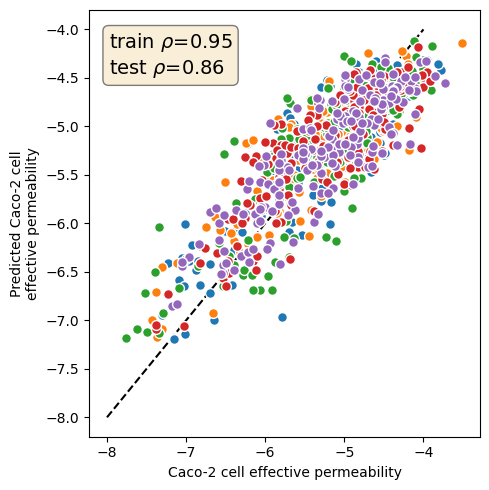

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

for fold in folds:
    ax.scatter(fold['y_te'], fold['y_te_pred_mu'], s=50, edgecolor='white')
    
ax.set_xlabel('Caco-2 cell effective permeability')
ax.set_ylabel('Predicted Caco-2 cell\neffective permeability')

ax.plot([-8,-4], [-8,-4], linestyle='--', color='k', zorder=0)

text_str = r'train $\rho$=0.95'+'\n'+r'test $\rho$=0.86'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('caco2_ngboost_mordred_pairity.png', dpi=300)

In [21]:
fold_stats_tr

{'r2_mean': 0.8952293990315491,
 'r2_stderr': 0.0022112960650559946,
 'mae_mean': 0.20274347524154498,
 'mae_stderr': 0.0019717443507857283,
 'rmse_mean': 0.06318823147714611,
 'rmse_stderr': 0.0011459844743738682,
 'pears_mean': 0.9510505979302977,
 'pears_stderr': 0.0009982997838049192,
 'spear_mean': 0.9367283657525197,
 'spear_stderr': 0.0009498790170053489}

In [22]:
fold_stats_te

{'r2_mean': 0.7386479231563337,
 'r2_stderr': 0.004491932228858959,
 'mae_mean': 0.31752840324674636,
 'mae_stderr': 0.005138441327093734,
 'rmse_mean': 0.15740051471433641,
 'rmse_stderr': 0.005076096986623338,
 'pears_mean': 0.8622810227709486,
 'pears_stderr': 0.0024556149681575824,
 'spear_mean': 0.8278180016235883,
 'spear_stderr': 0.005178940050829765}

In [67]:
# train on entire Caco-2 dataset and predict on abl kinase inhibitors

# featurize the entire caco-2 dataset

smi = df['molecule_smi'].tolist()
mols = [mfs(s) for s in smi]
calc=Calculator(descriptors,ignore_3D=True,version='1.0.0')
mord_df = calc.pandas(mols)
mord_df = mord_df.select_dtypes(exclude=['object', 'bool'])
X_tr = mord_df.values


smi = abl_df['molecule_smi'].tolist()
mols = [mfs(s) for s in smi]
calc=Calculator(descriptors,ignore_3D=True,version='1.0.0')
mord_df = calc.pandas(mols)
mord_df = mord_df.select_dtypes(exclude=['object', 'bool'])
X_te = mord_df.values


    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 270/270 [00:31<00:00,  8.48it/s]


(910, 915)

In [72]:
y_tr = df['y'].values.reshape(-1, 1)


(910, 1)

In [73]:
model_cac = NGBRegressor().fit(X_tr, y_tr)
    


[iter 0] loss=1.1664 val_loss=0.0000 scale=1.0000 norm=0.8456
[iter 100] loss=0.7304 val_loss=0.0000 scale=1.0000 norm=0.5824
[iter 200] loss=0.4380 val_loss=0.0000 scale=1.0000 norm=0.5004
[iter 300] loss=0.2369 val_loss=0.0000 scale=1.0000 norm=0.4740
[iter 400] loss=0.0998 val_loss=0.0000 scale=2.0000 norm=0.9391


In [81]:
# train set prediction
y_preds_tr = model.predict(X_tr)
y_dists_tr = model.pred_dist(X_tr)
samples_tr = y_dists_tr.sample(m=50).T
y_std_tr = np.std(samples_tr, axis=-1)
y_mu_tr = np.mean(samples_tr, axis=-1)

In [82]:
# test set (abl kinase prediction)
y_preds_te = model.predict(X_te)
y_dists_te = model.pred_dist(X_te)
samples_te = y_dists_te.sample(m=50).T
y_std_te = np.std(samples_te, axis=-1)
y_mu_te = np.mean(samples_te, axis=-1)

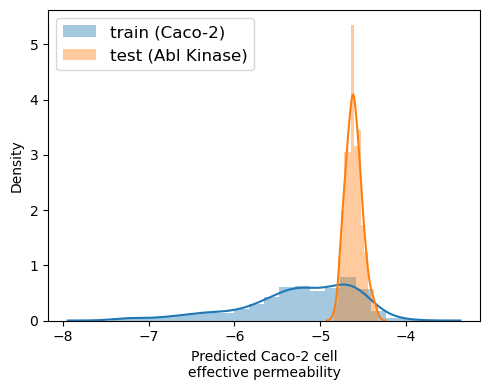

In [86]:
# compare the distribuions of predictions on train and test (OOD) set

fig,ax = plt.subplots(figsize=(5, 4))

sns.distplot(y_mu_tr, label='train (Caco-2)', ax=ax)
sns.distplot(y_mu_te, label='test (Abl Kinase)', ax=ax)

ax.legend(loc='upper left',fontsize=12)
ax.set_xlabel('Predicted Caco-2 cell\neffective permeability')

plt.tight_layout()
plt.savefig('extrapolation_values.png', dpi=300)


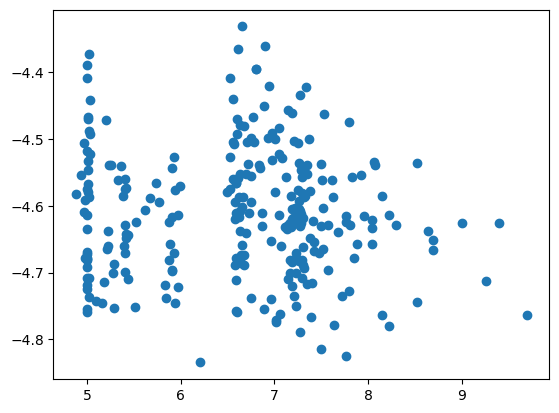

In [88]:
# check the correlation of the permeability values and the IC50s

fig,ax = plt.subplots()

pic50 = abl_df['abl1_pIC50'].values

ax.scatter(pic50, y_mu_te)



## Acute Toxicity LD50

In [37]:
data = Tox(name = 'LD50_Zhu')
tox_df = data.get_data()
tox_df = tox_df.rename(columns={'Drug':'molecule_smi', 'Y': 'y'})
print(tox_df.shape)
tox_df.head()

Found local copy...
Loading...
Done!


(7385, 3)


,Drug_ID,molecule_smi,y
0,"Diazene, diphenyl-, 1-oxide",[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,"Methane, tribromo-",BrC(Br)Br,2.343
2,Bromoethene (9CI),C=CBr,2.330
3,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729


In [65]:
folds = featurize_regression(df, num_folds=5, fold_size=1477)

False


In [66]:
# train regression model on folds
fold_metrics_te = []
fold_metrics_tr = []

for fold in folds:
    X_tr, y_tr = fold['X_tr'], fold['y_tr']
    X_te, y_te = fold['X_te'], fold['y_te']
    
    
    print(X_tr.shape, y_tr.shape)
    print(X_te.shape, y_te.shape)
    
    model = NGBRegressor().fit(X_tr, y_tr)
    
    # train set prediction
    y_preds_tr = model.predict(X_tr)
    y_dists_tr = model.pred_dist(X_tr)
    samples_tr = y_dists_tr.sample(m=50).T
    y_std_tr = np.std(samples_tr, axis=-1)
    y_mu_tr = np.mean(samples_tr, axis=-1)
    
    
    
    # rescale the targets and predictions
    #y_mu_tr = fold['scaler'].inverse_transform(y_mu_tr)
    #y_tr = fold['scaler'].inverse_transform(y_tr)
    
    metrics_tr = get_metrics_regression(y_tr, y_mu_tr)
    fold_metrics_tr.append(metrics_tr)
    
    fold['y_tr_pred_mu'] = y_mu_tr.reshape(-1, 1)
    fold['y_tr_pred_std'] = y_std_tr.reshape(-1, 1)
    

    # test set prediction
    y_preds_te = model.predict(X_te)
    y_dists_te = model.pred_dist(X_te)
    samples_te = y_dists_te.sample(m=50).T
    y_std_te = np.std(samples_te, axis=-1)
    y_mu_te = np.mean(samples_te, axis=-1)
    
    #y_mu_te = fold['scaler'].inverse_transform(y_mu_te)
    #y_te = fold['scaler'].inverse_transform(y_te)
    
    metrics_te = get_metrics_regression(y_te, y_mu_te)
    
    fold_metrics_te.append(metrics_te)
    
    fold['y_te_pred_mu'] = y_mu_te.reshape(-1, 1)
    fold['y_te_pred_std'] = y_std_te.reshape(-1, 1)

(5908, 1024) (5908, 1)
(1477, 1024) (1477, 1)
[iter 0] loss=1.3765 val_loss=0.0000 scale=1.0000 norm=0.9728
[iter 100] loss=1.1865 val_loss=0.0000 scale=1.0000 norm=0.8339
[iter 200] loss=1.1011 val_loss=0.0000 scale=1.0000 norm=0.7993
[iter 300] loss=1.0460 val_loss=0.0000 scale=1.0000 norm=0.7815
[iter 400] loss=1.0063 val_loss=0.0000 scale=1.0000 norm=0.7698
(5908, 1024) (5908, 1)
(1477, 1024) (1477, 1)
[iter 0] loss=1.3886 val_loss=0.0000 scale=1.0000 norm=0.9804
[iter 100] loss=1.1954 val_loss=0.0000 scale=1.0000 norm=0.8391
[iter 200] loss=1.1132 val_loss=0.0000 scale=1.0000 norm=0.8060
[iter 300] loss=1.0570 val_loss=0.0000 scale=1.0000 norm=0.7882
[iter 400] loss=1.0163 val_loss=0.0000 scale=1.0000 norm=0.7746
(5908, 1024) (5908, 1)
(1477, 1024) (1477, 1)
[iter 0] loss=1.3723 val_loss=0.0000 scale=1.0000 norm=0.9700
[iter 100] loss=1.1833 val_loss=0.0000 scale=1.0000 norm=0.8321
[iter 200] loss=1.0962 val_loss=0.0000 scale=1.0000 norm=0.7972
[iter 300] loss=1.0417 val_loss=0.00

KeyboardInterrupt: 

## Abl kinase dataset

In [113]:
def make_pca_analysis(name, type_):
    # get abl kinase
    abl_df = pd.read_csv('lookup_table.csv')
    abl_smi = abl_df['molecule_smi'].tolist()
    abl_mols = [mfs(s) for s in abl_smi]
    abl_X = np.array([
        AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in abl_mols
    ]).astype(np.float32)
    
    # other dataset
    if type_=='adme':
        data=ADME(name=name)
    elif type_=='tox':
        data=Tox(name=name)
    else:
        raise NotImplementedError
    df = data.get_data()
    
    smi = df['Drug'].tolist()
    mols = [mfs(s) for s in smi]
    X = np.array([
        AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in mols
    ]).astype(np.float32)
    
    X_comb = np.concatenate((abl_X, X))
    
    pca = PCA(n_components=2)
    X_trans = pca.fit_transform(X_comb)
    
    return X_trans

In [114]:
datasets = [
    ['LD50_Zhu', 'tox'],
    ['HydrationFreeEnergy_FreeSolv', 'adme'],
    ['Solubility_AqSolDB', 'adme'],
    ['Lipophilicity_AstraZeneca', 'adme'],
    ['Caco2_Wang', 'adme'],
    ['PPBR_AZ', 'adme'],
    ['VDss_Lombardo', 'adme'],
    ['Half_Life_Obach', 'adme'],
    ['Clearance_Hepatocyte_AZ', 'adme'],
]

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen atom without neighbors
[19:30:06] WARNING: not removing hydrogen at

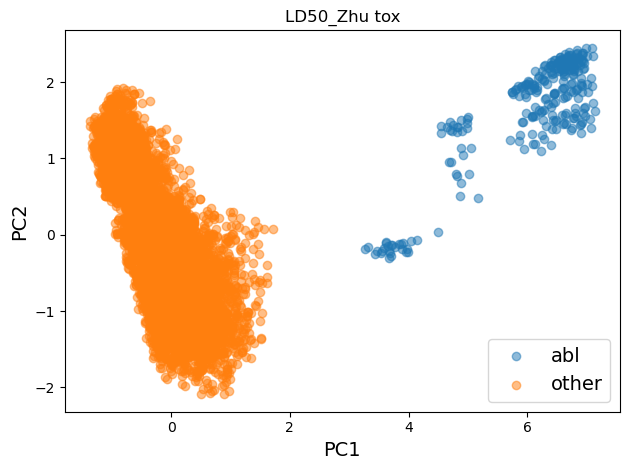

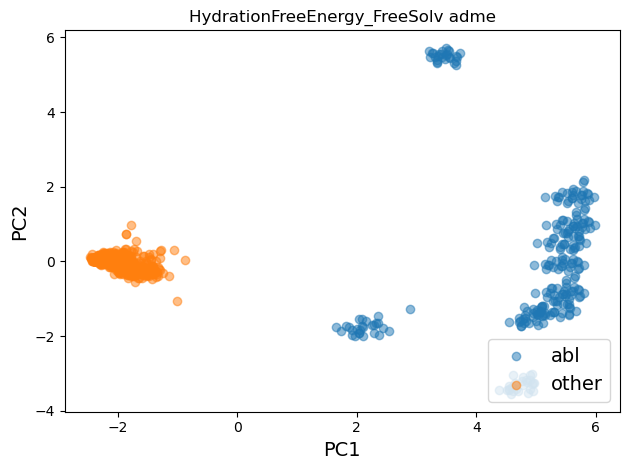

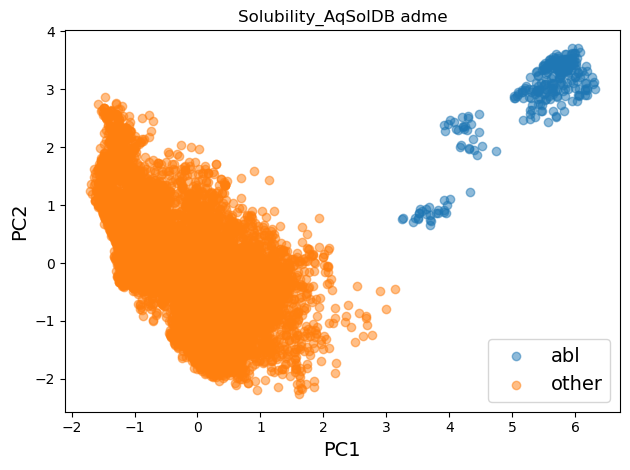

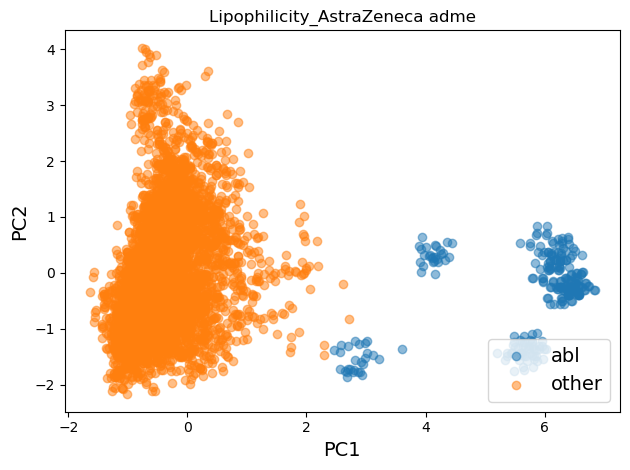

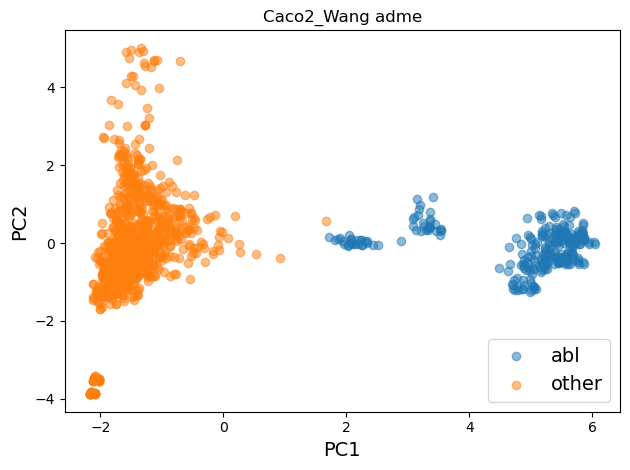

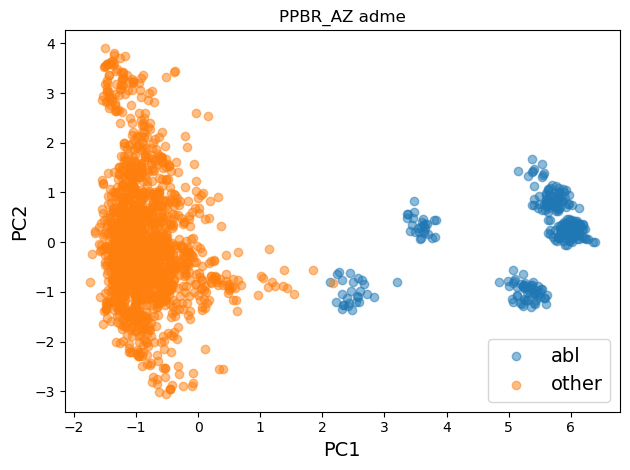

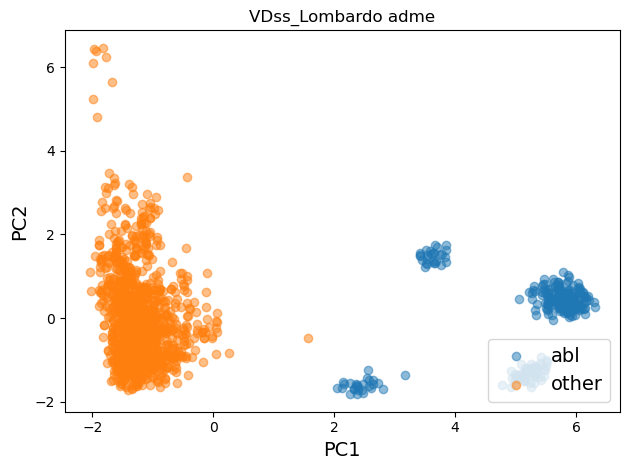

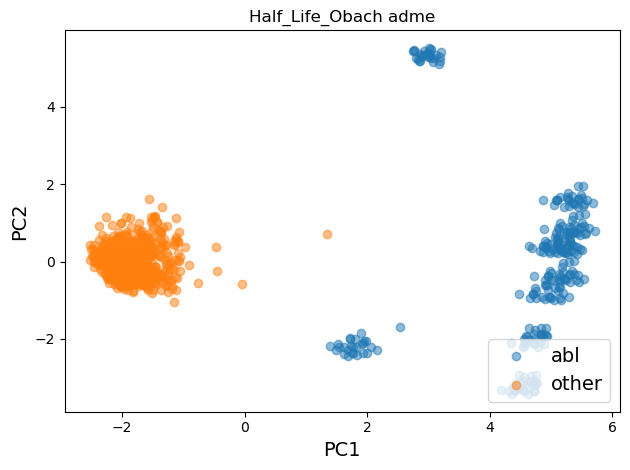

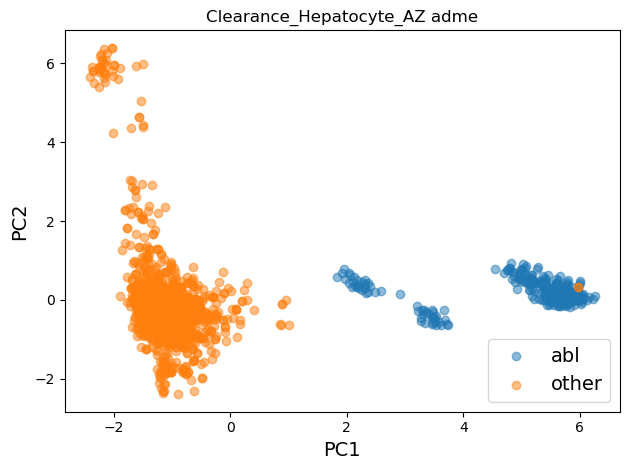

In [115]:
for dataset in datasets:
    name, type_ = dataset
    
    X_trans = make_pca_analysis(name, type_)
    
    fig, ax = plt.subplots()
    ax.scatter(X_trans[:abl_X.shape[0], 0], X_trans[:abl_X.shape[0], 1], label='abl', alpha=0.5)
    ax.scatter(X_trans[abl_X.shape[0]:, 0], X_trans[abl_X.shape[0]:, 1], label='other', alpha=0.5)

    ax.set_xlabel('PC1',fontsize=14)
    ax.set_ylabel('PC2',fontsize=14)
    ax.set_title(name +' '+type_)
    ax.legend(loc='lower right', fontsize=14)

    plt.tight_layout()
    plt.savefig(name+'.png', dpi=300)

In [31]:
abl_df = pd.read_csv('lookup_table.csv')
print(abl_df.shape)
abl_df.head()

(270, 10)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000
2,8-1,22-3,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(F)(F)F)cn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,0,0.000000,1,7.515735,7.152991
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000


In [91]:
# solubility dataset
data = ADME(name='Solubility_AqSolDB')
sol_df = data.get_data()
print(sol_df.shape)
sol_df.head()

Found local copy...
Loading...
Done!


(9982, 3)


,Drug_ID,Drug,Y
0,"N,N,N-trimethyloctadecan-1-aminium bromide",CCCCCCCCCCCCCCCCCC[N+](C)(C)C.[Br-],-3.616127
1,Benzo[cd]indol-2(1H)-one,O=C1Nc2cccc3cccc1c23,-3.254767
2,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
3,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",CC(c1ccccc1)c1cc(C(=O)[O-])c(O)c(C(C)c2ccccc2)...,-3.924409
4,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,c1cc(N(CC2CO2)CC2CO2)ccc1Cc1ccc(N(CC2CO2)CC2CO...,-4.662065


In [94]:
# lipophilicity 
data = ADME(name='Lipophilicity_AstraZeneca')
lipo_df = data.get_data()
print(lipo_df.shape)
lipo_df.head()

Downloading...
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 298k/298k [00:00<00:00, 4.36MiB/s]
Loading...
Done!


(4200, 3)


,Drug_ID,Drug,Y
0,CHEMBL596271,Cn1c(CN2CCN(c3ccc(Cl)cc3)CC2)nc2ccccc21,3.54
1,CHEMBL1951080,COc1cc(OC)c(S(=O)(=O)N2c3ccccc3CCC2C)cc1NC(=O)...,-1.18
2,CHEMBL1771,COC(=O)[C@H](c1ccccc1Cl)N1CCc2sccc2C1,3.69
3,CHEMBL234951,O=C(NC1Cc2ccccc2N(C[C@@H](O)CO)C1=O)c1cc2cc(Cl...,3.37
4,CHEMBL565079,Cc1cccc(C[C@H](NC(=O)c2cc(C(C)(C)C)nn2C)C(=O)N...,3.10


In [102]:
data = Tox(name='hERG')
herg_df = data.get_data()
print(herg_df.shape)
herg_df.head()

Downloading...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50.2k/50.2k [00:00<00:00, 2.41MiB/s]
Loading...
Done!


(655, 3)


,Drug_ID,Drug,Y
0,DEMETHYLASTEMIZOLE,Oc1ccc(CCN2CCC(Nc3nc4ccccc4n3Cc3ccc(F)cc3)CC2)cc1,1.0
1,GBR-12909,Fc1ccc(C(OCC[NH+]2CC[NH+](CCCc3ccccc3)CC2)c2cc...,1.0
2,LY-97241,CCCCCCCN(CC)CCCCc1ccc([N+](=O)[O-])cc1,1.0
3,CLOFILIUM PHOSPHATE,CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1.CCCCCCC[N+...,1.0
4,FLUSPIRILENE,O=C1NCN(c2ccccc2)C12CC[NH+](CCCC(c1ccc(F)cc1)c...,1.0


In [93]:
sol_smi = sol_df['Drug'].tolist()
sol_mols = [mfs(s) for s in sol_smi]
sol_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in sol_mols]).astype(np.float32)

[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:41] WARNING: not removing hydrogen atom without neighbors
[19:04:42] WARNING: not removing hydrogen atom without neighbors
[19:04:42] WARNING: not removing hydrogen atom without neighbors
[19:04:42] WARNING: not removing hydrogen atom without neighbors
[19:04:42] WARNING: not removing hydrogen atom without neighbors
[19:04:42] WARNING: not r

In [95]:
# lipophilicity
lipo_smi = lipo_df['Drug'].tolist()
lipo_mols = [mfs(s) for s in lipo_smi]
lipo_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in lipo_mols]).astype(np.float32)

In [105]:

herg_smi = herg_df['Drug'].tolist()
herg_mols = [mfs(s) for s in herg_smi]
herg_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in herg_mols]).astype(np.float32)

[19:11:52] WARNING: not removing hydrogen atom without neighbors
[19:11:52] WARNING: not removing hydrogen atom without neighbors


In [38]:
abl_smi = abl_df['molecule_smi'].tolist()
abl_mols = [mfs(s) for s in abl_smi]
abl_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in abl_mols]).astype(np.float32)

In [39]:
tox_smi = tox_df['molecule_smi'].tolist()
tox_mols = [mfs(s) for s in tox_smi]
tox_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in tox_mols]).astype(np.float32)

In [40]:
cac_smi = df['molecule_smi'].tolist()
cac_mols = [mfs(s) for s in cac_smi]
cac_X = np.array([AllChem.GetMorganFingerprintAsBitVect(m,3,nBits=2048) for m in cac_mols]).astype(np.float32)

In [41]:
X_abl_cac = np.concatenate((abl_X, cac_X))
X_abl_cac.shape

(1180, 2048)

In [42]:
X_abl_tox = np.concatenate((abl_X, tox_X))
X_abl_tox.shape

(7655, 2048)

In [96]:
X_abl_sol = np.concatenate((abl_X, sol_X))
X_abl_sol.shape

(10252, 2048)

In [97]:
X_abl_lipo = np.concatenate((abl_X, lipo_X))
X_abl_lipo.shape

(4470, 2048)

In [106]:
X_abl_herg = np.concatenate((abl_X, herg_X))
X_abl_herg.shape

(925, 2048)

In [57]:
pca = PCA(n_components=2)
X_trans_abl_tox = pca.fit_transform(X_abl_tox)

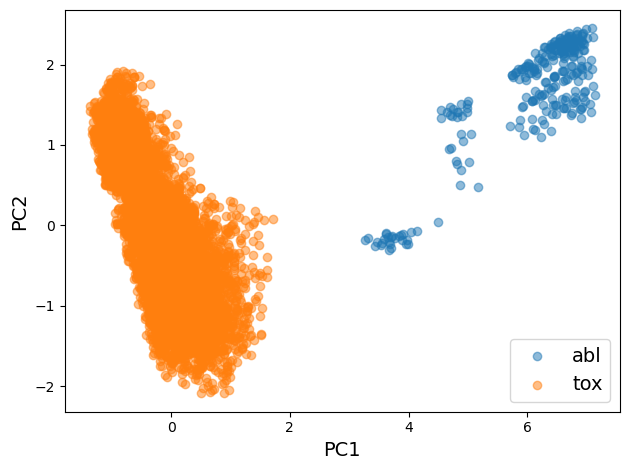

In [58]:
fig, ax = plt.subplots()

ax.scatter(X_trans_abl_tox[:abl_X.shape[0], 0], X_trans_abl_tox[:abl_X.shape[0], 1], label='abl', alpha=0.5)
ax.scatter(X_trans_abl_tox[abl_X.shape[0]:, 0], X_trans_abl_tox[abl_X.shape[0]:, 1], label='tox', alpha=0.5)

ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()
plt.savefig('abl_tox_ecfp_pca.png',dpi=300)

In [60]:
pca = PCA(n_components=2)
X_trans_abl_cac = pca.fit_transform(X_abl_cac)

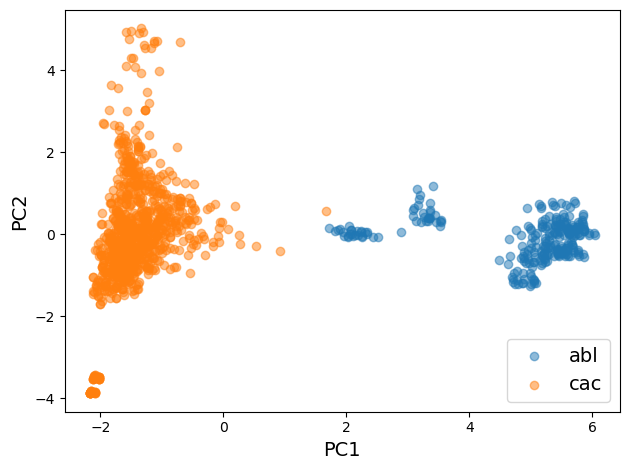

In [61]:
fig, ax = plt.subplots()

ax.scatter(X_trans_abl_cac[:abl_X.shape[0], 0], X_trans_abl_cac[:abl_X.shape[0], 1], label='abl', alpha=0.5)
ax.scatter(X_trans_abl_cac[abl_X.shape[0]:, 0], X_trans_abl_cac[abl_X.shape[0]:, 1], label='cac', alpha=0.5)

ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()
plt.savefig('abl_cac_ecfp_pca.png',dpi=300)

In [98]:
pca = PCA(n_components=2)
X_trans_abl_sol = pca.fit_transform(X_abl_sol)

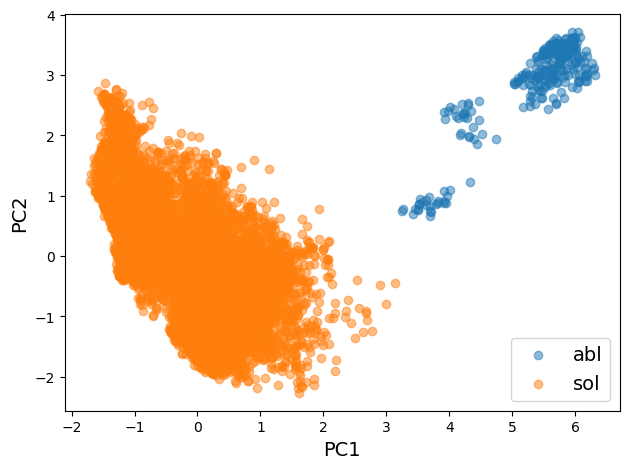

In [99]:
fig, ax = plt.subplots()

ax.scatter(X_trans_abl_sol[:abl_X.shape[0], 0], X_trans_abl_sol[:abl_X.shape[0], 1], label='abl', alpha=0.5)
ax.scatter(X_trans_abl_sol[abl_X.shape[0]:, 0], X_trans_abl_sol[abl_X.shape[0]:, 1], label='sol', alpha=0.5)

ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()

In [100]:
pca = PCA(n_components=2)
X_trans_abl_lipo = pca.fit_transform(X_abl_lipo)

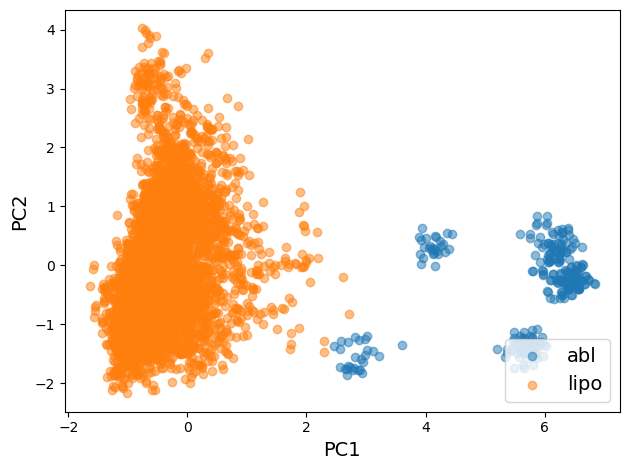

In [101]:
fig, ax = plt.subplots()

ax.scatter(X_trans_abl_lipo[:abl_X.shape[0], 0], X_trans_abl_lipo[:abl_X.shape[0], 1], label='abl', alpha=0.5)
ax.scatter(X_trans_abl_lipo[abl_X.shape[0]:, 0], X_trans_abl_lipo[abl_X.shape[0]:, 1], label='lipo', alpha=0.5)

ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()

In [107]:
pca = PCA(n_components=2)
X_trans_abl_herg = pca.fit_transform(X_abl_herg)

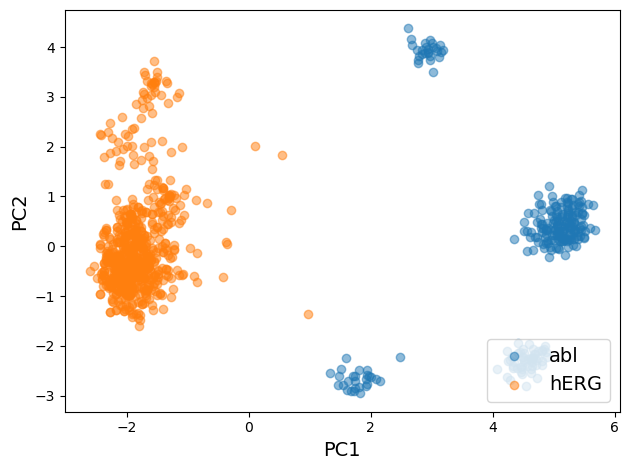

In [108]:
fig, ax = plt.subplots()

ax.scatter(X_trans_abl_herg[:abl_X.shape[0], 0], X_trans_abl_herg[:abl_X.shape[0], 1], label='abl', alpha=0.5)
ax.scatter(X_trans_abl_herg[abl_X.shape[0]:, 0], X_trans_abl_herg[abl_X.shape[0]:, 1], label='hERG', alpha=0.5)

ax.set_xlabel('PC1',fontsize=14)
ax.set_ylabel('PC2',fontsize=14)
ax.legend(loc='lower right', fontsize=14)

plt.tight_layout()